In [ ]:
!nvidia-smi

In [2]:
import tensorflow
print(tensorflow.__version__)

2.3.1


In [3]:
### Imports ###
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
#from keras.engine.topology import Container
from keras.engine.network import Network
from keras.layers import *
from keras import backend
from keras.models import Model
from keras.preprocessing import image
import keras.backend as K

import matplotlib.pyplot as plt

import numpy as np
import os
import random
import scipy.misc
from tqdm import *

%matplotlib inline

In [4]:
### Constants ###
DATA_DIR = "../input/tiny-imagenet/tiny-imagenet-200"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")

IMG_SHAPE = (64, 64)

def load_dataset_small(num_images_per_class_train=10, num_images_test=500):
    """Loads training and test datasets, from Tiny ImageNet Visual Recogition Challenge.

    Arguments:
        num_images_per_class_train: number of images per class to load into training dataset.
        num_images_test: total number of images to load into training dataset.
    """

    X_train = []
    X_test = []
    
    # Create training set.
    for c in os.listdir("../input/tiny-imagenet/tiny-imagenet-200/train"):
        c_dir = os.path.join("../input/tiny-imagenet/tiny-imagenet-200/train", c, 'images')
        c_imgs = os.listdir(c_dir)
        random.shuffle(c_imgs)
        for img_name_i in c_imgs[0:num_images_per_class_train]:
            img_i = image.load_img(os.path.join(c_dir, img_name_i))
            x = image.img_to_array(img_i)
            X_train.append(x)
    random.shuffle(X_train)
    
    """
    # Create test set.
    test_dir = os.path.join(TEST_DIR, 'images')
    test_imgs = os.listdir(test_dir)
    random.shuffle(test_imgs)
    for img_name_i in test_imgs[0:num_images_test]:
        print("2")
        img_i = image.load_img(os.path.join(test_dir, img_name_i))
        x = image.img_to_array(img_i)
        X_test.append(x)
    """
    # Return train and test data as numpy arrays.
    #return np.array(X_train), np.array(X_test)
    return np.array(X_train)

In [5]:
# Load dataset.
#X_train_orig, X_test_orig = load_dataset_small()
X_train_orig = load_dataset_small()

# Normalize image vectors.
X_train = X_train_orig/255.
#X_test = X_test_orig/255.

# Print statistics.
print ("Number of training examples = " + str(X_train.shape[0]))
print ("Number of test examples = " + str(X_train.shape[0]))
print ("X_train shape: " + str(X_train.shape)) # Should be (train_size, 64, 64, 3).

Number of training examples = 2000
Number of test examples = 2000
X_train shape: (2000, 64, 64, 3)


In [6]:
# We split training set into two halfs.
# First half is used for training as secret images, second half for cover images.

# S1: secret image1
input_S1 = X_train[0:X_train.shape[0] // 4]
# S2: secret image2
input_S2 = X_train[X_train.shape[0] // 4 : 2*(X_train.shape[0] // 4)]
# S3: secret image3
input_S3 = X_train[2*(X_train.shape[0] // 4) : 3*(X_train.shape[0] // 4)]




# C: cover image
input_C = X_train[3*(X_train.shape[0] // 4):]

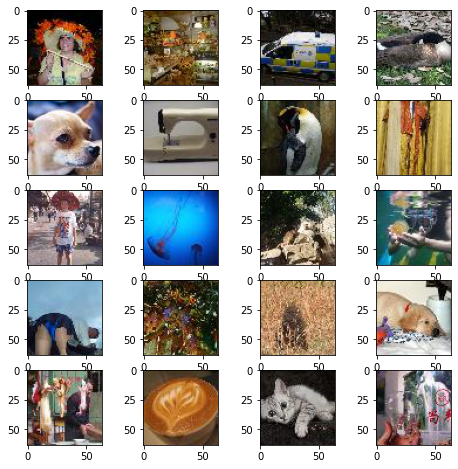

In [7]:
# Show sample images from the training dataset
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    # Randomly sample from training dataset
    img_idx = np.random.choice(X_train.shape[0])
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_train[img_idx])
plt.show()

**Model**

The model is composed of three parts: The Preparation Network, Hiding Network (Encoder) and the Reveal Network. Its goal is to be able to encode information about the secret image S into the cover image C, generating C' that closely resembles C, while still being able to decode information from C' to generate the decoded secret image S', which should resemble S as closely as possible.

The Preparation Network has the responsibility of preparing data from the secret image to be concatenated with the cover image and fed to the Hiding Network. The Hiding Network than transforms that input into the encoded cover image C'. Finally, the Reveal Network decodes the secret image S' from C'. For stability, we add noise before the Reveal Network, as suggested by the paper. Although the author of the paper didn't originally specify the architecture of the three networks, we discovered aggregated layers showed good results. For both the Hiding and Reveal networks, we use 5 layers of 65 filters (50 3x3 filters, 10 4x4 filters and 5 5x5 filters). For the preparation network, we use only 2 layers with the same structure.

Note that the loss function for the Reveal Network is different from the loss function for the Preparation and Hiding Networks. In order to correctly implement the updates for the weights in the networks, we create stacked Keras models, one for the Preparation and Hiding Network (which share the same loss function) and one for the Reveal Network. To make sure weights are updated only once, we freeze the weights on the layers of the Reveal Network before adding it to the full model.

In [8]:
# Variable used to weight the losses of the secret and cover images (See paper for more details)
beta = 1.0
    
# Loss for reveal network
def rev_loss(s_true, s_pred):
    # Loss for reveal network is: beta * |S-S'|
    #return s_true-s_pred

    print(s_true.shape, s_pred.shape)
    return beta * K.sum(K.square(s_true - s_pred))

# Loss for the full model, used for preparation and hidding networks
def full_loss(y_true, y_pred):
    # Loss for the full model is: |C-C'| + beta * |S-S'|
    print(y_true.shape, y_pred.shape)
    s1_true, s2_true, s3_true, c_true = y_true[...,0:3], y_true[...,3:6], y_true[...,6:9], y_true[...,9:12]
    s1_pred, s2_pred, s3_pred, c_pred = y_pred[...,0:3], y_pred[...,3:6], y_pred[...,6:9], y_pred[...,9:12]

    #s_loss = rev_loss(s_true, s_pred)
    s1_loss = beta * K.sum(K.square(s1_true - s1_pred))
    s2_loss = beta * K.sum(K.square(s2_true - s2_pred))
    s3_loss = beta * K.sum(K.square(s3_true - s3_pred))
    c_loss = K.sum(K.square(c_true - c_pred))
    
    return s1_loss + c_loss + s2_loss + s3_loss


# Returns the encoder as a Keras model, composed by Preparation and Hiding Networks.
def make_encoder(input_size):
    input_S1 = Input(shape=(input_size))
    input_S2 = Input(shape=(input_size))
    input_S3 = Input(shape=(input_size))
    input_C= Input(shape=(input_size))

    # Preparation Network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3_1')(input_S1)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4_1')(input_S1)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5_1')(input_S1)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3_1')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4_1')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5_1')(x)
    x1 = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3_2')(input_S2)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4_2')(input_S2)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5_2')(input_S2)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3_2')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4_2')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5_2')(x)
    x2 = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3_3')(input_S3)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4_3')(input_S3)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5_3')(input_S3)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3_3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4_3')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5_3')(x)
    x3_1 = concatenate([x3, x4, x5])
    
    x = concatenate([input_C, x1, x2, x3_1])
    
    # Hiding network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Cprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_C')(x)
    
    return Model(inputs=[input_S1, input_S2, input_S3, input_C],
                 outputs=output_Cprime,
                 name = 'Encoder')

# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder1(input_size, fixed=False):
    
    # Reveal network
    reveal_input = Input(shape=(input_size))
    
    # Adding Gaussian noise with 0.01 standard deviation.
    input_with_noise = GaussianNoise(0.01, name='output_C_noise1')(reveal_input)
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3_1')(input_with_noise)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4_1')(input_with_noise)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5_1')(input_with_noise)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3_1')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4_1')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5_1')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3_1')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4_1')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5_1')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3_1')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4_1')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5_1')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3_1')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4_1')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5_1')(x)
    x = concatenate([x3, x4, x5])
    
    output_S1prime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S1')(x)
    
    if not fixed:
        return Model(inputs=reveal_input,
                     outputs=output_S1prime)
    else:
        """return Container(inputs=reveal_input,
                         outputs=output_Sprime,
                         name = 'DecoderFixed')"""
        return Network(inputs=reveal_input,
                         outputs=output_S1prime)
        
# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder2(input_size, fixed=False):
    
    # Reveal network
    reveal_input = Input(shape=(input_size))
    
    # Adding Gaussian noise with 0.01 standard deviation.
    input_with_noise = GaussianNoise(0.01, name='output_C_noise2')(reveal_input)
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3_2')(input_with_noise)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4_2')(input_with_noise)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5_2')(input_with_noise)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3_2')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4_2')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5_2')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3_2')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4_2')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5_2')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3_2')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4_2')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5_2')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3_2')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4_2')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5_2')(x)
    x = concatenate([x3, x4, x5])
    
    output_S2prime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S2')(x)
    
    if not fixed:
        return Model(inputs=reveal_input,
                     outputs=output_S2prime)
    else:
        """return Container(inputs=reveal_input,
                         outputs=output_S2prime,
                         name = 'DecoderFixed')"""
        return Network(inputs=reveal_input,
                         outputs=output_S2prime)

# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder3(input_size, fixed=False):
    
    # Reveal network
    reveal_input = Input(shape=(input_size))
    
    # Adding Gaussian noise with 0.01 standard deviation.
    input_with_noise = GaussianNoise(0.01, name='output_C_noise2')(reveal_input)
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3')(input_with_noise)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4')(input_with_noise)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5')(input_with_noise)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_S3prime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S3')(x)
    
    if not fixed:
        return Model(inputs=reveal_input,
                     outputs=output_S3prime)
    else:
        """return Container(inputs=reveal_input,
                         outputs=output_S2prime,
                         name = 'DecoderFixed')"""
        return Network(inputs=reveal_input,
                         outputs=output_S3prime)

# Full model.
def make_model(input_size):
    input_S1 = Input(shape=(input_size))
    input_S2 = Input(shape=(input_size))
    input_S3 = Input(shape=(input_size))
    input_C= Input(shape=(input_size))
    
    encoder = make_encoder(input_size)
    
    decoder1 = make_decoder1(input_size)
    decoder1.compile(optimizer='adam', loss=rev_loss)
    decoder1.trainable = False

    decoder2 = make_decoder2(input_size)
    decoder2.compile(optimizer='adam', loss=rev_loss)
    decoder2.trainable = False

    decoder3 = make_decoder3(input_size)
    decoder3.compile(optimizer='adam', loss=rev_loss)
    decoder3.trainable = False
    
    output_Cprime = encoder([input_S1, input_S2, input_S3, input_C])
    output_S1prime = decoder1(output_Cprime)
    output_S2prime = decoder2(output_Cprime)
    output_S3prime = decoder3(output_Cprime)

    autoencoder1 = Model(inputs=[input_S1, input_S2, input_S3, input_C],
                        outputs=concatenate([output_S1prime, output_S2prime, output_S3prime, output_Cprime]))
    autoencoder1.compile(optimizer='adam', loss=full_loss)
    
    # autoencoder2 = Model(inputs=[input_S1, input_S2, input_C],
    #                     outputs=concatenate([output_S2prime, output_Cprime]))
    # autoencoder2.compile(optimizer='adam', loss=full_loss)


    return encoder, decoder1, decoder2, decoder3, autoencoder1

In [9]:
encoder_model, reveal_model1, reveal_model2, reveal_model3, autoencoder_model = make_model(input_S1.shape[1:])

# **Training**


Although the author of the paper didn't explicitly described the learning rate schedule or the optimizer properties, we used our own schedule with ADAM optimizer. We train for 1000 epochs with a batch size of 32.

In [10]:
def lr_schedule(epoch_idx):
    if epoch_idx < 200:
        return 0.001
    elif epoch_idx < 400:
        return 0.0003
    elif epoch_idx < 600:
        return 0.0001
    else:
        return 0.00003

In [12]:
NB_EPOCHS = 2
BATCH_SIZE = 256

m = input_S1.shape[0]
loss_history = []
#loss_history2 = []
for epoch in range(NB_EPOCHS):
    np.random.shuffle(input_S1)
    np.random.shuffle(input_S2)
    np.random.shuffle(input_S3)
    np.random.shuffle(input_C)
    
    t = tqdm(range(0, input_S1.shape[0], BATCH_SIZE),mininterval=0)
    ae_loss = []
    #ae_loss2 = []
    rev_loss1 = []
    rev_loss2 = []
    rev_loss3 = []
    for idx in t:
        
        batch_S1 = input_S1[idx:min(idx + BATCH_SIZE, m)]
        batch_S2 = input_S2[idx:min(idx + BATCH_SIZE, m)]
        batch_S3 = input_S3[idx:min(idx + BATCH_SIZE, m)]
        batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
        
        C_prime = encoder_model.predict([batch_S1, batch_S2, batch_S3, batch_C])
        
        ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S1, batch_S2, batch_S3, batch_C],
                                                   y=np.concatenate((batch_S1, batch_S2, batch_S3, batch_C),axis=3)))
        #ae_loss2.append(autoencoder_model2.train_on_batch(x=[batch_S1, batch_S2, batch_C],
        #                                           y=np.concatenate((batch_S2, batch_C),axis=3)))
        rev_loss1.append(reveal_model1.train_on_batch(x=C_prime,
                                              y=batch_S1))
        rev_loss2.append(reveal_model2.train_on_batch(x=C_prime,
                                              y=batch_S2))
        rev_loss3.append(reveal_model3.train_on_batch(x=C_prime,
                                              y=batch_S3))
        
        # Update learning rate
        K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
        #K.set_value(autoencoder_model2.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model1.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model2.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model3.optimizer.lr, lr_schedule(epoch))
        
        t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev1 {:10.2f} | Loss Rev2 {:10.2f} | Loss Rev3 {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss1), np.mean(rev_loss2), np.mean(rev_loss3)))
    
    autoencoder_model.save_weights('models/model3_'+str(epoch))
    #autoencoder_model2.save_weights('models/model'+str(epoch))
    
    loss_history.append(np.mean(ae_loss))
    #loss_history2.append(np.mean(ae_loss2))

Epoch 1 | Batch: 256 of 500. Loss AE 3015329.00 | Loss Rev1  678860.94 | Loss Rev2  752334.66 | Loss Rev3  910062.12: 100%|██████████| 2/2 [00:06<00:00,  3.48s/it]
Epoch 2 | Batch: 256 of 500. Loss AE 2722849.75 | Loss Rev1  594270.34 | Loss Rev2  717160.38 | Loss Rev3  699815.22: 100%|██████████| 2/2 [00:06<00:00,  3.46s/it]


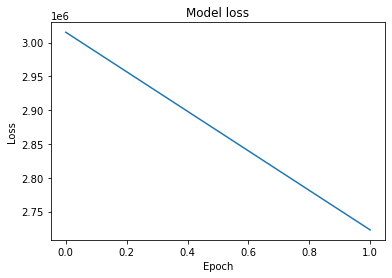

In [13]:
1# Plot loss through epochs
plt.plot(loss_history)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [14]:
for epoch in range(5):
    np.random.shuffle(input_S1)
    np.random.shuffle(input_S2)
    np.random.shuffle(input_S3)
    np.random.shuffle(input_C)
    
    t = tqdm(range(0, input_S1.shape[0], BATCH_SIZE),mininterval=0)
    ae_loss = []
    rev_loss1 = []
    rev_loss2 = []
    rev_loss3 = []
    for idx in t:
        
        batch_S1 = input_S1[idx:min(idx + BATCH_SIZE, m)]
        batch_S2 = input_S2[idx:min(idx + BATCH_SIZE, m)]
        batch_S3 = input_S3[idx:min(idx + BATCH_SIZE, m)]
        batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
        
        C_prime = encoder_model.predict([batch_S1, batch_S2, batch_S3, batch_C])
        
        ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S1, batch_S2, batch_S3, batch_C],
                                                   y=np.concatenate((batch_S1, batch_S2, batch_S3, batch_C),axis=3)))
        rev_loss1.append(reveal_model1.train_on_batch(x=C_prime,
                                              y=batch_S1))
        rev_loss2.append(reveal_model2.train_on_batch(x=C_prime,
                                              y=batch_S2))
        rev_loss3.append(reveal_model3.train_on_batch(x=C_prime,
                                              y=batch_S3))
        
        # Update learning rate
        K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model1.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model2.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model3.optimizer.lr, lr_schedule(epoch))
        
        t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev1 {:10.2f} | Loss Rev2 {:10.2f} | Loss Rev3 {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss1), np.mean(rev_loss2), np.mean(rev_loss3)))
    
    autoencoder_model.save_weights('models/model3_'+str(epoch+6))
    
    loss_history.append(np.mean(ae_loss))

Epoch 1 | Batch: 256 of 500. Loss AE 2511825.88 | Loss Rev1  510916.38 | Loss Rev2  601836.34 | Loss Rev3  722082.75: 100%|██████████| 2/2 [00:06<00:00,  3.44s/it]
Epoch 2 | Batch: 256 of 500. Loss AE 2048864.56 | Loss Rev1  344960.52 | Loss Rev2  473317.73 | Loss Rev3  703644.91: 100%|██████████| 2/2 [00:06<00:00,  3.45s/it]
Epoch 3 | Batch: 256 of 500. Loss AE 1774425.38 | Loss Rev1  264588.30 | Loss Rev2  287305.63 | Loss Rev3  684915.12: 100%|██████████| 2/2 [00:06<00:00,  3.42s/it]
Epoch 4 | Batch: 256 of 500. Loss AE 1664122.19 | Loss Rev1  282241.21 | Loss Rev2  242071.53 | Loss Rev3  681711.69: 100%|██████████| 2/2 [00:06<00:00,  3.42s/it]
Epoch 5 | Batch: 256 of 500. Loss AE 1537736.62 | Loss Rev1  238645.69 | Loss Rev2  244071.90 | Loss Rev3  677379.69: 100%|██████████| 2/2 [00:06<00:00,  3.45s/it]


In [15]:
for epoch in range(50):
    np.random.shuffle(input_S1)
    np.random.shuffle(input_S2)
    np.random.shuffle(input_S3)
    np.random.shuffle(input_C)
    
    t = tqdm(range(0, input_S1.shape[0], BATCH_SIZE),mininterval=0)
    ae_loss = []
    rev_loss1 = []
    rev_loss2 = []
    rev_loss3 = []
    for idx in t:
        
        batch_S1 = input_S1[idx:min(idx + BATCH_SIZE, m)]
        batch_S2 = input_S2[idx:min(idx + BATCH_SIZE, m)]
        batch_S3 = input_S3[idx:min(idx + BATCH_SIZE, m)]
        batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
        
        C_prime = encoder_model.predict([batch_S1, batch_S2, batch_S3, batch_C])
        
        ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S1, batch_S2, batch_S3, batch_C],
                                                   y=np.concatenate((batch_S1, batch_S2, batch_S3, batch_C),axis=3)))
        rev_loss1.append(reveal_model1.train_on_batch(x=C_prime,
                                              y=batch_S1))
        rev_loss2.append(reveal_model2.train_on_batch(x=C_prime,
                                              y=batch_S2))
        rev_loss3.append(reveal_model3.train_on_batch(x=C_prime,
                                              y=batch_S3))
        
        # Update learning rate
        K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model1.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model2.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model3.optimizer.lr, lr_schedule(epoch))
        
        t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev1 {:10.2f} | Loss Rev2 {:10.2f} | Loss Rev3 {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss1), np.mean(rev_loss2), np.mean(rev_loss3)))
    
    autoencoder_model.save_weights('models/model3_'+str(epoch+6))
    
    loss_history.append(np.mean(ae_loss))

Epoch 1 | Batch: 256 of 500. Loss AE 1364263.19 | Loss Rev1  221054.23 | Loss Rev2  241175.40 | Loss Rev3  627288.88: 100%|██████████| 2/2 [00:06<00:00,  3.48s/it]
Epoch 2 | Batch: 256 of 500. Loss AE 1151261.62 | Loss Rev1  200725.03 | Loss Rev2  228274.76 | Loss Rev3  484832.62: 100%|██████████| 2/2 [00:06<00:00,  3.46s/it]
Epoch 3 | Batch: 256 of 500. Loss AE 1028953.97 | Loss Rev1  196954.66 | Loss Rev2  216746.12 | Loss Rev3  382941.97: 100%|██████████| 2/2 [00:06<00:00,  3.48s/it]
Epoch 4 | Batch: 256 of 500. Loss AE  874381.12 | Loss Rev1  192310.95 | Loss Rev2  209743.07 | Loss Rev3  240342.04: 100%|██████████| 2/2 [00:06<00:00,  3.43s/it]
Epoch 5 | Batch: 256 of 500. Loss AE  878992.88 | Loss Rev1  201729.38 | Loss Rev2  209571.20 | Loss Rev3  241778.48: 100%|██████████| 2/2 [00:06<00:00,  3.47s/it]
Epoch 6 | Batch: 256 of 500. Loss AE  883406.25 | Loss Rev1  199485.54 | Loss Rev2  213829.19 | Loss Rev3  249704.23: 100%|██████████| 2/2 [00:06<00:00,  3.49s/it]
Epoch 7 | Batch:

In [16]:
for epoch in range(700):
    np.random.shuffle(input_S1)
    np.random.shuffle(input_S2)
    np.random.shuffle(input_S3)
    np.random.shuffle(input_C)
    
    t = tqdm(range(0, input_S1.shape[0], BATCH_SIZE),mininterval=0)
    ae_loss = []
    rev_loss1 = []
    rev_loss2 = []
    rev_loss3 = []
    for idx in t:
        
        batch_S1 = input_S1[idx:min(idx + BATCH_SIZE, m)]
        batch_S2 = input_S2[idx:min(idx + BATCH_SIZE, m)]
        batch_S3 = input_S3[idx:min(idx + BATCH_SIZE, m)]
        batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
        
        C_prime = encoder_model.predict([batch_S1, batch_S2, batch_S3, batch_C])
        
        ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S1, batch_S2, batch_S3, batch_C],
                                                   y=np.concatenate((batch_S1, batch_S2, batch_S3, batch_C),axis=3)))
        rev_loss1.append(reveal_model1.train_on_batch(x=C_prime,
                                              y=batch_S1))
        rev_loss2.append(reveal_model2.train_on_batch(x=C_prime,
                                              y=batch_S2))
        rev_loss3.append(reveal_model3.train_on_batch(x=C_prime,
                                              y=batch_S3))
        
        # Update learning rate
        K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model1.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model2.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model3.optimizer.lr, lr_schedule(epoch))
        
        t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev1 {:10.2f} | Loss Rev2 {:10.2f} | Loss Rev3 {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss1), np.mean(rev_loss2), np.mean(rev_loss3)))
    
    autoencoder_model.save_weights('models/model3_'+str(epoch+6))
    
    loss_history.append(np.mean(ae_loss))

Epoch 1 | Batch: 256 of 500. Loss AE  474901.30 | Loss Rev1   78276.63 | Loss Rev2  133859.30 | Loss Rev3   95017.93: 100%|██████████| 2/2 [00:06<00:00,  3.39s/it]
Epoch 2 | Batch: 256 of 500. Loss AE  468612.64 | Loss Rev1   76956.99 | Loss Rev2  136259.59 | Loss Rev3   93513.44: 100%|██████████| 2/2 [00:06<00:00,  3.44s/it]
Epoch 3 | Batch: 256 of 500. Loss AE  464620.61 | Loss Rev1   76926.64 | Loss Rev2  135783.33 | Loss Rev3   92319.66: 100%|██████████| 2/2 [00:06<00:00,  3.41s/it]
Epoch 4 | Batch: 256 of 500. Loss AE  458280.50 | Loss Rev1   75813.08 | Loss Rev2  132141.37 | Loss Rev3   94246.69: 100%|██████████| 2/2 [00:06<00:00,  3.43s/it]
Epoch 5 | Batch: 256 of 500. Loss AE  456734.08 | Loss Rev1   76228.97 | Loss Rev2  129606.28 | Loss Rev3   96355.49: 100%|██████████| 2/2 [00:06<00:00,  3.44s/it]
Epoch 6 | Batch: 256 of 500. Loss AE  445161.31 | Loss Rev1   75134.78 | Loss Rev2  127220.92 | Loss Rev3   92700.20: 100%|██████████| 2/2 [00:06<00:00,  3.41s/it]
Epoch 7 | Batch:

In [17]:
BATCH_SIZE = 32
for epoch in range(400):
    np.random.shuffle(input_S1)
    np.random.shuffle(input_S2)
    np.random.shuffle(input_S3)
    np.random.shuffle(input_C)
    
    t = tqdm(range(0, input_S1.shape[0], BATCH_SIZE),mininterval=0)
    ae_loss = []
    rev_loss1 = []
    rev_loss2 = []
    rev_loss3 = []
    for idx in t:
        
        batch_S1 = input_S1[idx:min(idx + BATCH_SIZE, m)]
        batch_S2 = input_S2[idx:min(idx + BATCH_SIZE, m)]
        batch_S3 = input_S3[idx:min(idx + BATCH_SIZE, m)]
        batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
        
        C_prime = encoder_model.predict([batch_S1, batch_S2, batch_S3, batch_C])
        
        ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S1, batch_S2, batch_S3, batch_C],
                                                   y=np.concatenate((batch_S1, batch_S2, batch_S3, batch_C),axis=3)))
        rev_loss1.append(reveal_model1.train_on_batch(x=C_prime,
                                              y=batch_S1))
        rev_loss2.append(reveal_model2.train_on_batch(x=C_prime,
                                              y=batch_S2))
        rev_loss3.append(reveal_model3.train_on_batch(x=C_prime,
                                              y=batch_S3))
        
        # Update learning rate
        K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model1.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model2.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model3.optimizer.lr, lr_schedule(epoch))
        
        t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f} | Loss Rev2 {:10.2f} | Loss Rev3 {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss1), np.mean(rev_loss2), np.mean(rev_loss3)))
    
    autoencoder_model.save_weights('models/model_A21_'+str(epoch))
    
    loss_history.append(np.mean(ae_loss))

  0%|          | 0/16 [00:00<?, ?it/s]

(None, 64, 64, 12) (None, 64, 64, 12)
(None, 64, 64, 3) (None, 64, 64, 3)
(None, 64, 64, 3) (None, 64, 64, 3)
(None, 64, 64, 3) (None, 64, 64, 3)


Epoch 1 | Batch: 480 of 500. Loss AE   30940.35 | Loss Rev    5631.77 | Loss Rev2    7880.14 | Loss Rev3   11176.08: 100%|██████████| 16/16 [00:13<00:00,  1.22it/s]
Epoch 2 | Batch: 480 of 500. Loss AE   27004.31 | Loss Rev    5758.35 | Loss Rev2    6861.26 | Loss Rev3    7818.56: 100%|██████████| 16/16 [00:08<00:00,  1.95it/s]
Epoch 3 | Batch: 480 of 500. Loss AE   25014.00 | Loss Rev    5175.61 | Loss Rev2    6269.78 | Loss Rev3    7124.95: 100%|██████████| 16/16 [00:08<00:00,  1.96it/s]
Epoch 4 | Batch: 480 of 500. Loss AE   24150.59 | Loss Rev    5005.68 | Loss Rev2    6039.81 | Loss Rev3    6797.89: 100%|██████████| 16/16 [00:08<00:00,  1.95it/s]
Epoch 5 | Batch: 480 of 500. Loss AE   23847.77 | Loss Rev    5043.44 | Loss Rev2    5991.86 | Loss Rev3    6673.08: 100%|██████████| 16/16 [00:08<00:00,  1.96it/s]
Epoch 6 | Batch: 480 of 500. Loss AE   23678.72 | Loss Rev    4961.60 | Loss Rev2    5908.79 | Loss Rev3    6642.98: 100%|██████████| 16/16 [00:08<00:00,  1.96it/s]
Epoch 7 | 

In [18]:
autoencoder_model.load_weights('models/model_A21_399')

In [19]:
# Retrieve decoded predictions.
decoded = autoencoder_model.predict([input_S1, input_S2, input_S3, input_C])
decoded_S1, decoded_S2, decoded_S3, decoded_C = decoded[...,0:3], decoded[...,3:6], decoded[...,6:9], decoded[...,9:12]

# Get absolute difference between the outputs and the expected values.
diff_S1, diff_S2, diff_S3, diff_C = np.abs(decoded_S1 - input_S1), np.abs(decoded_S2 - input_S2), np.abs(decoded_S3 - input_S3), np.abs(decoded_C - input_C) 

In [20]:
def pixel_errors(input_S1, input_S2, input_S3, input_C, decoded_S1, decoded_S2, decoded_S3, decoded_C):
    """Calculates mean of Sum of Squared Errors per pixel for cover and secret images. """
    see_S1pixel = np.sqrt(np.mean(np.square(255*(input_S1 - decoded_S1))))
    see_S2pixel = np.sqrt(np.mean(np.square(255*(input_S2 - decoded_S2))))
    see_S3pixel = np.sqrt(np.mean(np.square(255*(input_S3 - decoded_S3))))
    see_Cpixel = np.sqrt(np.mean(np.square(255*(input_C - decoded_C))))
    
    return see_S1pixel, see_S2pixel, see_S3pixel, see_Cpixel

def pixel_histogram(diff_S1, diff_S2, diff_S3, diff_C):
    """Calculates histograms of errors for cover and secret image. """
    diff_S1flat = diff_S1.flatten()
    diff_S2flat = diff_S2.flatten()
    diff_S3flat = diff_S3.flatten()
    diff_Cflat = diff_C.flatten()
    
    fig = plt.figure(figsize=(15, 5))
    a=fig.add_subplot(1,2,1)
        
    imgplot = plt.hist(255* diff_Cflat, 100, normed=1, alpha=0.75, facecolor='red')
    a.set_title('Distribution of error in the Cover image.')
    plt.axis([0, 250, 0, 0.2])
    
    a=fig.add_subplot(1,2,2)
    imgplot = plt.hist(255* diff_S1flat, 100, normed=1, alpha=0.75, facSecolor='red')
    a.set_title('Distribution of errors in the Secret image1.')
    plt.axis([0, 250, 0, 0.2])

    a=fig.add_subplot(1,2,3)
    imgplot = plt.hist(255* diff_S2flat, 100, normed=1, alpha=0.75, facSecolor='red')
    a.set_title('Distribution of errors in the Secret image2.')
    plt.axis([0, 250, 0, 0.2])

    a=fig.add_subplot(1,2,4)
    imgplot = plt.hist(255* diff_S3flat, 100, normed=1, alpha=0.75, facSecolor='red')
    a.set_title('Distribution of errors in the Secret image3.')
    plt.axis([0, 250, 0, 0.2])
    
    plt.show()

In [21]:
# Print pixel-wise average errors in a 256 scale.
S1_error, S2_error, S3_error, C_error = pixel_errors(input_S1, input_S2, input_S3, input_C, decoded_S1, decoded_S2, decoded_S3, decoded_C)

print ("S1 error per pixel [0, 255]:", S1_error)
print ("S2 error per pixel [0, 255]:", S2_error)
print ("S2 error per pixel [0, 255]:", S3_error)
print ("C error per pixel [0, 255]:", C_error)

S1 error per pixel [0, 255]: 16.757511
S2 error per pixel [0, 255]: 18.342548
S2 error per pixel [0, 255]: 18.838432
C error per pixel [0, 255]: 26.987204


AttributeError: 'Rectangle' object has no property 'normed'

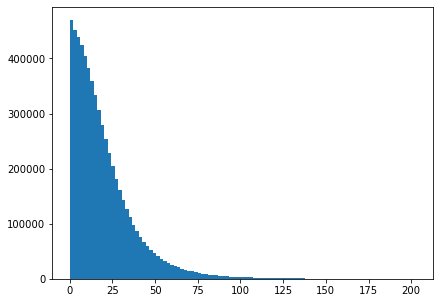

In [22]:
# Plot distribution of errors in cover and secret images.
pixel_histogram(diff_S1, diff_S2, diff_S3, diff_C)

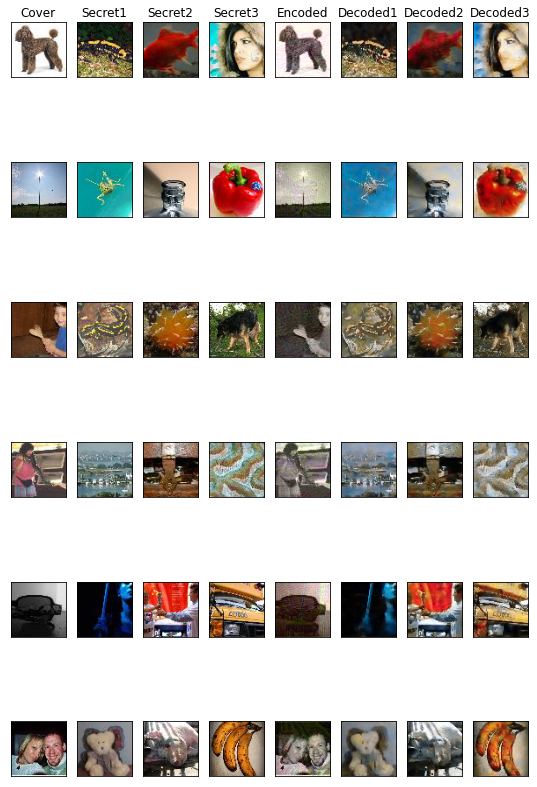

In [23]:
# Configs for results display

# Show images in gray scale
SHOW_GRAY = False
# Show difference bettwen predictions and ground truth.
SHOW_DIFF = True

# Diff enhance magnitude
ENHANCE = 1

# Number of secret and cover pairs to show.
n = 6

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def show_image(img, n_rows, n_col, idx, gray=False, first_row=False, title=None):
    ax = plt.subplot(n_rows, n_col, idx)
    if gray:
        plt.imshow(rgb2gray(img), cmap = plt.get_cmap('gray'))
    else:
        plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if first_row:
        plt.title(title)

plt.figure(figsize=(14, 15))
rand_indx = [random.randint(0, 500) for x in range(n)]
# for i, idx in enumerate(range(0, n)):
for i, idx in enumerate(rand_indx):
    n_col = 12 if SHOW_DIFF else 8
    
    show_image(input_C[idx], n, n_col, i * n_col + 1, gray=SHOW_GRAY, first_row=i==0, title='Cover')

    show_image(input_S1[idx], n, n_col, i * n_col + 2, gray=SHOW_GRAY, first_row=i==0, title='Secret1')

    show_image(input_S2[idx], n, n_col, i * n_col + 3, gray=SHOW_GRAY, first_row=i==0, title='Secret2')

    show_image(input_S3[idx], n, n_col, i * n_col + 4, gray=SHOW_GRAY, first_row=i==0, title='Secret3')
    
    show_image(decoded_C[idx], n, n_col, i * n_col + 5, gray=SHOW_GRAY, first_row=i==0, title='Encoded')
    
    show_image(decoded_S1[idx], n, n_col, i * n_col + 6, gray=SHOW_GRAY, first_row=i==0, title='Decoded1')

    show_image(decoded_S2[idx], n, n_col, i * n_col + 7, gray=SHOW_GRAY, first_row=i==0, title='Decoded2')

    show_image(decoded_S3[idx], n, n_col, i * n_col + 8, gray=SHOW_GRAY, first_row=i==0, title='Decoded3')

    
    # if SHOW_DIFF:
    #     show_image(np.multiply(diff_C[idx], ENHANCE), n, n_col, i * n_col + 9, gray=SHOW_GRAY, first_row=i==0, title='Diff Cover')
        
    #     show_image(np.multiply(diff_S1[idx], ENHANCE), n, n_col, i * n_col + 10, gray=SHOW_GRAY, first_row=i==0, title='Diff Secret1')

    #     show_image(np.multiply(diff_S2[idx], ENHANCE), n, n_col, i * n_col + 11, gray=SHOW_GRAY, first_row=i==0, title='Diff Secret2')

    #     show_image(np.multiply(diff_S3[idx], ENHANCE), n, n_col, i * n_col + 12, gray=SHOW_GRAY, first_row=i==0, title='Diff Secret3')

plt.show()